In [122]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
df = pd.read_csv('data/covid_19_data.csv')

In [123]:
# I referred code regarding data preprocessing from https://www.kaggle.com/chirag9073/coronavirus-covid-19-outbreak-data-analysis

df.drop(['SNo'], axis=1, inplace=True)
df['ObservationDate'] = df['ObservationDate'].apply(pd.to_datetime)

In [124]:
df.head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [125]:
df.isnull().sum()

ObservationDate      0
Province/State     982
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [126]:
df[df['Province/State'].isnull()].head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,2020-01-22,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0
36,2020-01-22,NaN,Thailand,1/22/2020 17:00,2.0,0.0,0.0
37,2020-01-22,NaN,South Korea,1/22/2020 17:00,1.0,0.0,0.0
73,2020-01-23,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0
74,2020-01-23,NaN,Thailand,1/23/20 17:00,3.0,0.0,0.0
75,2020-01-23,NaN,South Korea,1/23/20 17:00,1.0,0.0,0.0
76,2020-01-23,NaN,Singapore,1/23/20 17:00,1.0,0.0,0.0
77,2020-01-23,NaN,Philippines,1/23/20 17:00,0.0,0.0,0.0
78,2020-01-23,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
79,2020-01-23,NaN,Vietnam,1/23/20 17:00,2.0,0.0,0.0


In [127]:
# Current situation
grouped_df = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
grouped_df.style.background_gradient(cmap='Pastel1_r')

In [128]:
# Top 10 Countries with most no. of reported cases
latest_df = df[df['ObservationDate'] == max(df['ObservationDate'])].reset_index()
grouped_df = latest_df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

temp = grouped_df[['Country/Region', 'Confirmed']]
temp = temp.sort_values(by='Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.head(10).style.background_gradient(cmap='Pastel1_r')

,Country/Region,Confirmed
0,Mainland China,80026
1,South Korea,4335
2,Italy,2036
3,Iran,1501
4,Others,705
5,Japan,274
6,France,191
7,Germany,159
8,Spain,120
9,Singapore,108


In [129]:
# Countries with all the cases recovered
temp = grouped_df[grouped_df['Confirmed']==grouped_df['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Vietnam,16,16
1,Cambodia,1,1
2,Nepal,1,1
3,Sri Lanka,1,1


In [130]:
# Most recent stats
world_daily_df = df.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
world_daily_df = world_daily_df.reset_index()
world_daily_df = world_daily_df.sort_values('ObservationDate', ascending=False)
world_daily_df.head(1).style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602


In [131]:
world_daily_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602
39,2020-03-01 00:00:00,88371,2996,42716
38,2020-02-29 00:00:00,86013,2941,39782
37,2020-02-28 00:00:00,84124,2872,36711
36,2020-02-27 00:00:00,82756,2814,33277
35,2020-02-26 00:00:00,81397,2770,30384
34,2020-02-25 00:00:00,80415,2708,27905
33,2020-02-24 00:00:00,79570,2629,25227
32,2020-02-23 00:00:00,78985,2469,23394
31,2020-02-22 00:00:00,78599,2458,22886


In [132]:
world_daily_df.isnull().sum()

ObservationDate    0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [133]:
# from https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
import keras

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [134]:

import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

WINDOW_SIZE = 4

class PandemicRegressor():
    def __init__(self, window_size, batch_size, n_feature, model_name, stateful=False, loss_hist=None):
        self.window_size = window_size
        self.batch_size = batch_size
        self.n_feature = n_feature
        save_dir = os.path.join(os.path.join(os.getcwd(), 'model'), 
                                datetime.datetime.now().strftime('%Y-%m-%d;%H.%M.%S'))
        os.mkdir(save_dir)
        
        self.model_path = os.path.join(save_dir, model_name + '.best.hdf5')
        
        if stateful:
            self.callbacks = [loss_hist]
        else:
            self.callbacks = [EarlyStopping(monitor='loss', patience=20), 
                 ModelCheckpoint(self.model_path, monitor='mae', verbose=0, save_best_only=True, mode='min')]
        self.reg = self.build_model(stateful)
        
    def build_model(self, stateful):
        model = Sequential()
        if stateful:
            model.add(LSTM(1024, batch_input_shape=(self.batch_size, self.window_size, self.n_feature), dropout=0.5, stateful=True))
        else:
            model.add(LSTM(1024, input_shape=(self.window_size, self.n_feature), dropout=0.5))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.n_feature, activation='linear'))

        model.compile(loss='mean_squared_error', 
                      optimizer='adam',
                      metrics=['mae', 'mape'])
        return model
    
    def reset_states():
        # reset hiden states
        self.reg.reset_states()
    
    def fit(self, X_train, y_train, X_val, y_val, epochs=500, verbose=1, shuffle=False):
        hist = self.reg.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=self.batch_size,
                            #validation_data=(X_val, y_val),
                            callbacks=self.callbacks,
                            verbose=verbose,
                           shuffle=shuffle)
        return hist
    
    def predict_n_days(self, n, seq_in):
        seq_in = list(seq_in)
        seq_out = []
        for i in range(n):
            temp = np.array(seq_in)
            temp = np.reshape(temp, (1, self.window_size, self.n_feature)) # n_sample, seq_len, n_feature
            y_hat = self.reg.predict(temp)
            seq_out.append(y_hat[0])
            y_hat = (y_hat - _mean) / _std
            seq_in.append(y_hat[0])
            seq_in.pop(0)
        return pd.DataFrame(seq_out)
    
    def predict(self, X):
        return self.reg.predict(X)
    
    def evaluate(self, X_test, y_test):
        loss_and_metrics = self.reg.evaluate(X_test, 
                                             y_test, 
                                             batch_size=self.batch_size)
        return loss_and_metrics
    
    def load_best_weights(self):
        self.reg.load_weights(self.model_path)
        print('load best weights from ' + self.model_path)
    
    def save(self, name):
        self.reg.save(os.path.join(self.save_dir, name))
        print('saved in ' + os.path.join(self.save_dir, name))

In [135]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def show_train_hist(hist):
    plt.plot(hist.history['loss'], 'b-', label='train_loss')
    # plt.plot(hist.history['val_loss'], 'r', label='val_loss')
    plt.title("loss history")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Normalize
_mean = np.mean(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)

print(_mean)
print(_std)

[46077.41463415  1313.85365854 11462.34146341]
[31966.13245523  1056.92768198 13683.82920771]


In [136]:
def seq2dataset(sr, window_size):
        seq_data = []
        for i in range(len(sr) - window_size):
            subset = list(sr[i:(i+window_size+1)])
            subset.reverse()
            seq_data.append(subset)
        seq_data.reverse()
        seq_data = np.array(seq_data)
        return seq_data[:,0:window_size,:], seq_data[:,window_size,:]

In [137]:
X, y = seq2dataset(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X

array([[[  555.,    17.,    28.],
        [  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.]],

       [[  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.]],

       [[  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.]],

       [[ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.]],

       [[ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.]],

       [[ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.]],

       [[ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.],
        [ 9925.,   213.,   222.]],

       [[ 6165.,   133.,   126.],


In [138]:
y

array([[ 2118.,    56.,    52.],
       [ 2927.,    82.,    61.],
       [ 5578.,   131.,   107.],
       [ 6165.,   133.,   126.],
       [ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80

In [139]:
X = (X - _mean) / _std

In [140]:
X

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817]],

       [[-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654]],

       [[-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [142]:
X_train

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817]],

       [[-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654]],

       [[-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-

In [143]:
X_test

array([[[1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238]],

       [[1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512]],

       [[1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255]],

       [[1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255],
        [1.19021547, 1.47422228, 1.84514569]],

       [[1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255],
        [1.19021547, 1.47422228, 1.84514569],
        [1.24930926, 1.53950584, 2.06957118]],

       [[1.14742018, 1.41934625, 1.59419255],
        [1.19021547, 1.4

In [144]:
y_train

array([[ 2118.,    56.,    52.],
       [ 2927.,    82.,    61.],
       [ 5578.,   131.,   107.],
       [ 6165.,   133.,   126.],
       [ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80

In [145]:
y_test

array([[81397.,  2770., 30384.],
       [82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86013.,  2941., 39782.],
       [88371.,  2996., 42716.],
       [90309.,  3085., 45602.]])

Epoch 1/1000
31/31 [==============================] - 1s 27ms/step - loss: 960099443.6129 - mae: 17744.6035 - mape: 99.9999
Epoch 2/1000
31/31 [==============================] - 0s 2ms/step - loss: 959965001.8065 - mae: 17742.7285 - mape: 99.8460
Epoch 3/1000
31/31 [==============================] - 0s 2ms/step - loss: 958929143.2258 - mae: 17726.8320 - mape: 98.6722
Epoch 4/1000
31/31 [==============================] - 0s 2ms/step - loss: 952016917.1613 - mae: 17603.9082 - mape: 92.2703
Epoch 5/1000
31/31 [==============================] - 0s 2ms/step - loss: 919372791.2258 - mae: 17045.4824 - mape: 119.0592
Epoch 6/1000
31/31 [==============================] - 0s 2ms/step - loss: 819877170.3226 - mae: 15808.1533 - mape: 282.6103
Epoch 7/1000
31/31 [==============================] - 0s 2ms/step - loss: 654065261.4194 - mae: 14792.0664 - mape: 863.1252
Epoch 8/1000
31/31 [==============================] - 0s 2ms/step - loss: 543600918.7097 - mae: 14174.6387 - mape: 1065.0245
Epoch 9/10

31/31 [==============================] - 0s 2ms/step - loss: 100004695.0968 - mae: 6451.3032 - mape: 414.0380
Epoch 67/1000
31/31 [==============================] - 0s 2ms/step - loss: 144731309.9355 - mae: 7162.0386 - mape: 432.2119
Epoch 68/1000
31/31 [==============================] - 0s 2ms/step - loss: 169178649.2903 - mae: 7905.7822 - mape: 544.7687
Epoch 69/1000
31/31 [==============================] - 0s 2ms/step - loss: 62855744.3871 - mae: 5005.6255 - mape: 285.3572
Epoch 70/1000
31/31 [==============================] - 0s 2ms/step - loss: 146214474.3226 - mae: 6978.6050 - mape: 450.0540
Epoch 71/1000
31/31 [==============================] - 0s 2ms/step - loss: 112378536.5161 - mae: 6289.5127 - mape: 408.9319
Epoch 72/1000
31/31 [==============================] - 0s 2ms/step - loss: 118778716.9032 - mae: 7198.2764 - mape: 406.6826
Epoch 73/1000
31/31 [==============================] - 0s 2ms/step - loss: 173405730.8387 - mae: 7856.4219 - mape: 581.3333
Epoch 74/1000
31/31 [==

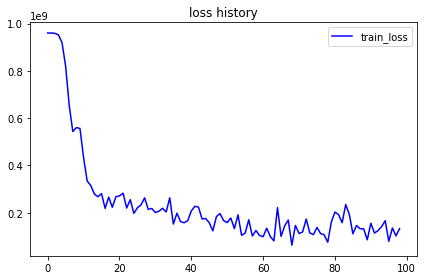

In [146]:
"""
Predict the global spread of coronavirus with LSTM modle
"""

pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, batch_size=8, n_feature=3, model_name='world_pdm_reg', stateful=False)

hist = pdm_reg.fit(X_train=X_train, 
                   y_train=y_train, 
                   X_val=X_test, 
                   y_val=y_test,
                   epochs=1000)
show_train_hist(hist)

In [147]:
pdm_reg.load_best_weights()

loss_and_metrics = pdm_reg.evaluate(X_test=X_test, 
                     y_test=y_test)
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = pdm_reg.predict(X_test)
print(y_hat)

n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = pdm_reg.predict_n_days(n, X_test[-1])
prediction

load best weights from C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;00.49.40\world_pdm_reg.best.hdf5
6/6 [==============================] - 0s 54ms/step
MAE: 6341.4765625, MAPE: 20.702537536621094
===================================================== Prediction of X_test =====================================================
[[84037.03    3438.2822 22111.52  ]
 [84084.99    3440.244  22124.143 ]
 [84190.305   3444.5542 22151.854 ]
 [84316.3     3449.7083 22184.998 ]
 [84415.29    3453.7576 22211.049 ]
 [84509.02    3457.5925 22235.709 ]]

===================================================== Prediction of 7 days =====================================================


,0,1,2
0,84509.015625,3457.592285,22235.708984
1,84562.953125,3459.799805,22249.904297
2,84629.203125,3462.510254,22267.335938
3,84654.039062,3463.526367,22273.871094
4,84092.187500,3440.543213,22126.031250
5,84093.929688,3440.616455,22126.498047
6,84096.609375,3440.725830,22127.193359


In [148]:
"""
Predict the global spread of coronavirus with LSTM modle
"""
loss_hist = LossHistory().init()
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, batch_size=1, n_feature=3, model_name='world_pdm_reg', stateful=True, loss_hist=loss_hist)

epochs = 1000
for i in range(1000):
    pdm_reg.fit(X_train=X_train, 
                   y_train=y_train, 
                   X_val=X_test, 
                   y_val=y_test,
                   epochs=1)
    pdm_reg.reset_states()

AttributeError: 'NoneType' object has no attribute 'set_model'

In [ ]:
plt.plot(loss_hist.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
loss_and_metrics = pdm_reg.evaluate(X_test=X_test, 
                     y_test=y_test)
pdm_reg.reset_states()

print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = pdm_reg.predict(X_test)
pdm_reg.reset_states()
print(y_hat)

n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = pdm_reg.predict_n_days(n, X_test[-1])
pdm_reg.reset_states()
print(prediction)

In [ ]:
print(df['Country/Region'].unique())
nation_name = 'South Korea'

In [ ]:
nation_df = df[df['Country/Region'] == nation_name].groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
nation_df = nation_df.reset_index()
nation_df = nation_df.sort_values('ObservationDate', ascending=False)
nation_df.style.background_gradient(cmap='Pastel1')

In [ ]:
# for nation_name in df['Country/Region'].unique():
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, batch_size=1, n_feature=3, model_name='nation_pdm_reg', patience=20)

print(f'[{nation_name} spread of coronavirus19]')
    
# Normalize
_mean = np.mean(nation_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(nation_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
    
X, y = seq2dataset(nation_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X = (X - _mean) / _std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

epochs = 300
history = LossHistory().init()

for i in range(epochs):
    
    hist = pdm_reg.fit(X_train=X_train, 
                       y_train=y_train,
                       epochs=1,
                       batch_size=1
                       X_val=X_test, 
                       y_val=y_test,
                       epochs=300)

show_train_hist(hist)

In [ ]:
pdm_reg.load_best_weights()
loss_and_metrics = pdm_reg.evaluate(X_test=X_test, 
                                        y_test=y_test)
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')

print(f'===================================================== Prediction of X_test =====================================================')
y_hat = pdm_reg.predict(X_test)
print(y_hat)
prediction = pdm_reg.predict_n_days(7, X_test[-1])
print(prediction)